In [1]:
import os
import numpy as np
import seaborn as sns
import librosa
import shutil
from io import BytesIO
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam

2024-03-08 12:09:21.427719: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 12:09:21.427821: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 12:09:21.613617: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
letters_paths=[
               '/kaggle/input/new-letters-spectrograms-200x200/letters_spectrograms200 (1)/letters_spectrograms/ثاء',
              '/kaggle/input/new-letters-spectrograms-200x200/letters_spectrograms200 (1)/letters_spectrograms/شين',
              '/kaggle/input/new-letters-spectrograms-200x200/letters_spectrograms200 (1)/letters_spectrograms/صاد',
              ]
data = []
labels = []
classes=['ثاء','شين','صاد']
counter=0
for letter_path in letters_paths:
    category=classes[counter]
    print(letter_path)
    print(category)
    for img_name in os.listdir(letter_path):
        img_path = os.path.join(letter_path, img_name)
        img = load_img(img_path, target_size=(100, 100))
        padded_img = ImageOps.expand(img, border=10, fill='white')
        img_array = img_to_array(padded_img)
        img_array /= 255.0
        data.append(img_array)
        labels.append(category)
    counter+=1

/kaggle/input/new-letters-spectrograms-200x200/letters_spectrograms200 (1)/letters_spectrograms/ثاء
ثاء
/kaggle/input/new-letters-spectrograms-200x200/letters_spectrograms200 (1)/letters_spectrograms/شين
شين
/kaggle/input/new-letters-spectrograms-200x200/letters_spectrograms200 (1)/letters_spectrograms/صاد
صاد


In [11]:
label_encoder = LabelEncoder()
encoded_label = label_encoder.fit_transform(labels)
categorical_labels = to_categorical(encoded_label)
X_train, X_test, y_train, y_test = train_test_split(data, categorical_labels, test_size=0.02, random_state=42)
X_test,X_val,y_test,y_val=train_test_split(X_test,y_test,test_size=0.5, random_state=42)
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)
print(f'X_train shape is {X_train.shape}')
print(f'X_val shape is {X_val.shape}')
print(f'X_test shape is {X_test.shape}')
print(f'y_train shape is {y_train.shape}')
print(f'y_val shape is {y_val.shape}')
print(f'y_test shape is {y_test.shape}')

X_train shape is (2331, 120, 120, 3)
X_val shape is (24, 120, 120, 3)
X_test shape is (24, 120, 120, 3)
y_train shape is (2331, 3)
y_val shape is (24, 3)
y_test shape is (24, 3)


# **Mobile Net**

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 3, 3, 1024)        3228864   
 onal)                                                           
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               1179776   
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 3)                 99        
                                                      

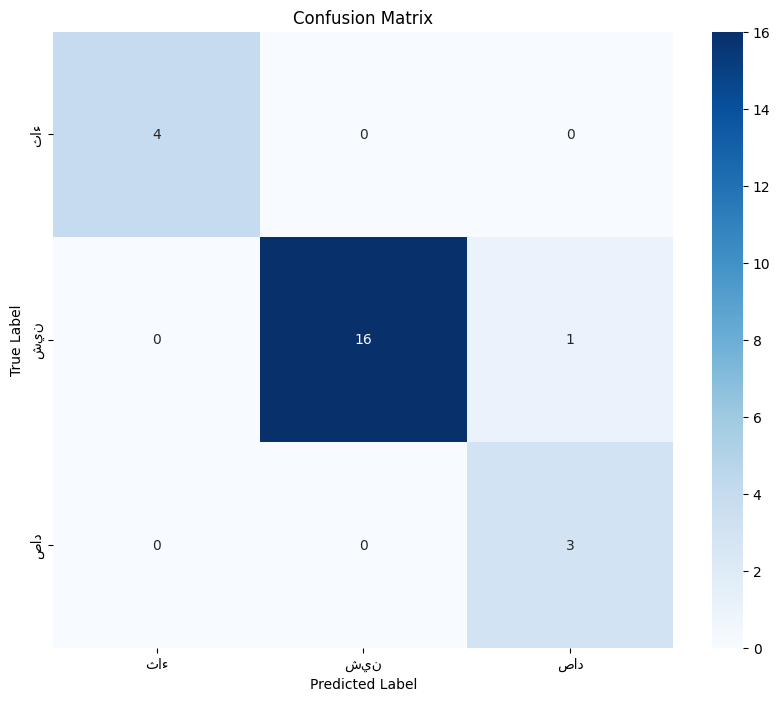


Classification Report:
              precision    recall  f1-score   support

         ثاء       1.00      1.00      1.00         4
         شين       1.00      0.94      0.97        17
         صاد       0.75      1.00      0.86         3

    accuracy                           0.96        24
   macro avg       0.92      0.98      0.94        24
weighted avg       0.97      0.96      0.96        24



In [14]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

input_shape = (120, 120, 3)
num_classes = 3  

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

model = Sequential([
    base_model,
    Flatten(),
    Dense(128,activation='relu'),
    Dense(64,activation='relu'),
    Dense(32,activation='relu'),
    Dense(num_classes, activation='softmax')  
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
print(model.summary())
# Train the model
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate confusion matrix and visualize
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print('\nClassification Report:')
print(classification_report(y_true_classes, y_pred_classes, target_names=classes))


In [24]:
signal,sr=librosa.load('/kaggle/input/test-letters/test letters/ص/WhatsApp Ptt 2024-02-29 at 6.22.40 PM.wav',sr=16000)
trimmed_signal, _ = librosa.effects.trim(signal)
normalized_audio = librosa.util.normalize(trimmed_signal)
duration=int(1*sr)
padded_audio = librosa.util.fix_length(trimmed_signal, size=duration)
mfcc_feature = librosa.feature.mfcc(y=signal, sr=16000, n_fft=1024,hop_length=30,n_mfcc=13)
scaler = StandardScaler()
mfcc_feature_standardized = scaler.fit_transform(mfcc_feature)
plt.figure(figsize=(1, 1))
librosa.display.specshow(librosa.amplitude_to_db(mfcc_feature_standardized,ref=np.max))
plt.colorbar(format='%+2.0f dB').remove()
buf = BytesIO()
plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0, transparent=True, dpi=100)
buf.seek(0)
image_name = "test_spectrogram.png"
image_path = "/kaggle/working/"+image_name
img = Image.open(buf)
img = img.resize((100, 100), Image.LANCZOS)
plt.close()
img=img.convert('RGB')
img_list=[]
padded_img = ImageOps.expand(img, border=10, fill='white')
img_array = img_to_array(padded_img)
img_array /= 255.0
img_list.append(img_array)
predictions=model.predict(np.array(img_list))
for i, prob in enumerate(predictions[0]):
    print(f"Probability of class {i}: {prob*100:.2f}%")
print(np.argmax(predictions, axis=1))

1/1 [==============================] - 0s 20ms/step
Probability of class 0: 0.00%
Probability of class 1: 0.00%
Probability of class 2: 100.00%
[2]


In [25]:
model_json = model.to_json()
with open("mobileNet_for_Tha_Sheen_Saud.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("mobileNet_for_Tha_Sheen_Saud_weights.h5")

In [2]:
from keras.models import model_from_json

with open('/kaggle/input/ready-models/mobileNet_for_alif_jeem_Ta.json', 'r') as f:
    model_json = f.read()

model = model_from_json(model_json)
model.load_weights('/kaggle/input/ready-models/mobileNet_for_alif_Ba_jeem_weights.h5')

# **Resnet**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
input_shape = (120, 120, 3)
num_classes = 28  
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
Resnet_model = Sequential([
    base_model,
    Flatten(),    
    Dense(800, activation='relu'),
    Dense(600, activation='relu'),
    Dense(500, activation='relu'),
    Dense(200, activation='relu'),
    Dense(100,activation='relu'),
    Dense(60,activation='relu'),
    Dense(num_classes, activation='softmax')  
])
optimizer = Adam(learning_rate=0.0001)
Resnet_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# Define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
print(Resnet_model.summary())
# Train the model
history = Resnet_model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)
# Evaluate the model on test data
test_loss, test_accuracy = Resnet_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
# Make predictions
y_pred = Resnet_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
# Generate confusion matrix and visualize
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print('\nClassification Report:')
print(classification_report(y_true_classes, y_pred_classes, target_names=categories))

# **VGG16**

In [ ]:
##### import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

input_shape = (120, 120, 3)
num_classes = 28  

base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

VGG16_model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')  
])

optimizer = Adam(learning_rate=0.0001)
VGG16_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model
history = VGG16_model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model on test data
test_loss, test_accuracy = VGG16_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Make predictions
y_pred = VGG16_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate confusion matrix and visualize
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print('\nClassification Report:')
print(classification_report(y_true_classes, y_pred_classes, target_names=categories))


In [ ]:
import os
import json
from tensorflow.keras.models import model_from_json
with open("/kaggle/input/resnet/Resnet/Resnet_model.json", "r") as json_file:
    model = json_file.read()

model = model_from_json(model)
model.load_weights("/kaggle/input/resnet/Resnet/Resnet_model_weights.h5")

In [ ]:
import whisper

model = whisper.load_model("base")
result = model.transcribe("/kaggle/input/arabic-letters-speech/Alphabet Classification (Multi-Class)/الف/0_0_Alif_T1.wav")
print(result["text"])
